# Bike Share Dataset

chicago bike share database link: https://divvybikes.com/system-data

In [4]:
import pandas as pd
import os

In [5]:
wardlink = "shp-files/geo_export_d3d31329-03f4-4e7d-b26b-c4e56f396f03.shp"
folder = 'bike-datasets'
resultFolder = 'results/bike-results'
resultFile = 'result.csv'

In [6]:
rename = ['station_name', 'station_id', 'station_lat', 'station_lng']
resultDf = pd.DataFrame(columns=rename)
count = 0

for file in os.listdir(folder):
    count += 1 
    iterableDf = pd.read_csv(f'{folder}/{file}')
    iterableDf.dropna(inplace=True)

    start_df = iterableDf[['start_station_name','start_station_id','start_lat','start_lng']]
    end_df = iterableDf[['end_station_name','end_station_id','end_lat','end_lng']]

    start_df.columns = rename
    end_df.columns = rename

    resultDf = pd.concat([resultDf,start_df,end_df],join='inner',ignore_index=True)


resultDf.drop_duplicates(subset=['station_id'],inplace=True)
print(f'{count} datasets filtrados\ndataset final contém {resultDf.shape[0]} estações')

40 datasets filtrados
dataset final contém 2191 estações


# Outlier Detection

In [7]:
import statistics as st

In [8]:
def determine_outliers(data: list):
    '''
    Função responsável por calcular quartis, amplitude interquartil e 
    retornar listas de outliers moderados e extremos de um conjunto de dados.
    '''
    sorted_data = sorted(data)

    Q = st.quantiles(sorted_data)
    A = Q[2] - Q[0]

    print(f"Quartis:\n{Q}\n")
    print(f"Amplitude interquartil: {A}\n")

    mod = []
    ext = []

    for i in data:
        if (i < Q[0]-1.5*A) or (i > Q[2]+1.5*A):
            mod.append(i)

        if (i < Q[0]-3*A) or (i > Q[2]+3*A):
            ext.append(i)

    print(f"{len(mod)} outlier(s) moderado(s):\n{mod}\n"\
    f"\n{len(ext)} outlier(s) extremo(s):\n{ext}")

    return mod, ext

In [9]:
lo = resultDf['station_lng'].to_list()
la = resultDf['station_lat'].to_list()

print('Quartis Latitude:')
mod_lat,ext_lat = determine_outliers(la)

print('\n\nQuartis Longitude:')
mod_lng,ext_lng = determine_outliers(lo)

print('\n\nOutlier:')

outlier = resultDf.loc[resultDf['station_lng'] == ext_lng[0]]
filted_coords = resultDf.drop(outlier.index)

resultDf.to_csv(f'{resultFolder}/{resultFile}', index=False)

outlier

Quartis Latitude:
Quartis:
[41.7875, 41.879356, 41.93]

Amplitude interquartil: 0.1424999999999983

1 outlier(s) moderado(s):
[45.635034323]

1 outlier(s) extremo(s):
[45.635034323]


Quartis Longitude:
Quartis:
[-87.7048707493, -87.6656, -87.631942]

Amplitude interquartil: 0.07292874930000437

15 outlier(s) moderado(s):
[-87.83, -87.82, -87.83, -73.79647696, -87.82, -87.82, -87.817114353, -87.836491942, -87.819081783, -87.82, -87.84, -87.84, -87.82, -87.82, -87.82]

1 outlier(s) extremo(s):
[-73.79647696]


Outlier:


,station_name,station_id,station_lat,station_lng
15113116,Pawel Bialowas - Test- PBSC charging station,Pawel Bialowas - Test- PBSC charging station,45.635034,-73.796477


## Visual Representation

chicago shp file from: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

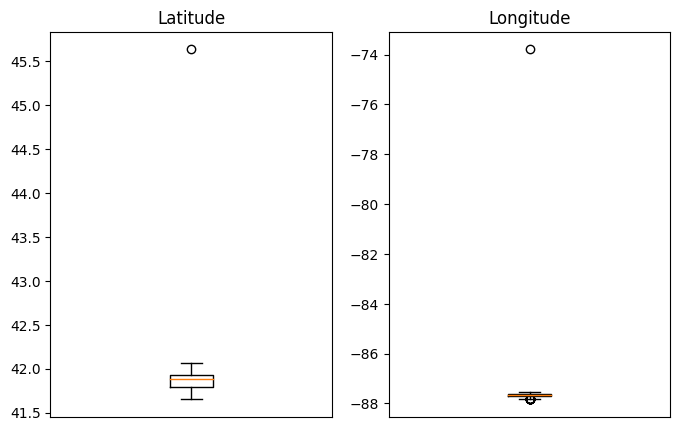

In [11]:
figure, axis = plt.subplots(1, 2, figsize=(8,5))

axis[0].boxplot(la)
axis[0].set_title("Latitude")
axis[0].set_xticks([])

axis[1].boxplot(lo)
axis[1].set_title("Longitude")
axis[1].set_xticks([])
plt.show()

# Map Plot

In [12]:
def map_plot(title,lat,lng,shpLink,savePath=None):
    ward = gpd.read_file(shpLink, bbox=None, mask=None, rows=None)
    geometry = [Point(xy) for xy in zip(lng,lat)]
    geo_df = gpd.GeoDataFrame(geometry = geometry)

    ward.crs = {'init':"epsg:4326"}
    geo_df.crs = {'init':"epsg:4326"}

    ax = ward.plot(alpha=0.35, color='#d66058', zorder=1, figsize=(8,8))
    ax = gpd.GeoSeries(ward['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)
    ax.axis('off')
    ax.set_title(title)

    ax = geo_df.plot(ax = ax, markersize = 20, color = 'blue',marker = '.',label = 'Chicago', zorder=3)

    ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    if savePath != None:
        try:
            plt.savefig(savePath,format='pdf',bbox_inches='tight')
        except:
            print("path not found")
    plt.show()


## With outlier:

c:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


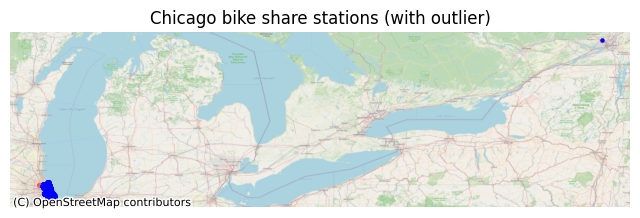

In [13]:
mapfile = f'{resultFolder}/mapBikeOutlier.pdf'
title = 'Chicago bike share stations (with outlier)'
map_plot(title,la,lo,wardlink,mapfile)

## Without Outlier:

c:\Users\camil\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


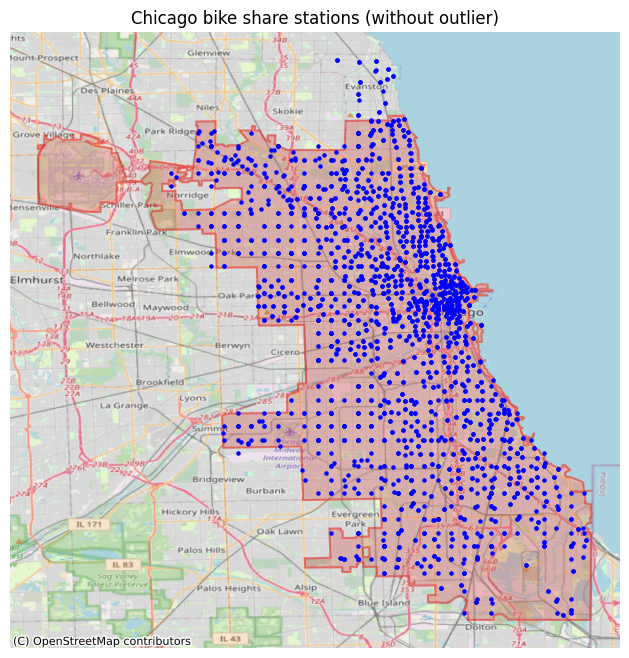

In [14]:
mapfile = f'{resultFolder}/mapBike.pdf'
title = 'Chicago bike share stations (without outlier)'

lo = filted_coords['station_lng'].to_list()
la = filted_coords['station_lat'].to_list()

map_plot(title,la,lo,wardlink,mapfile)